# Stochastic Simulation Assignment 2

# Todo list:

#### 2)
use some z/t/etc test

In [1]:
# Imports

import simpy
import queue
import numpy.random as rand
import numpy as np
import matplotlib.pyplot as plt

from stochasticQueueing import *

## 2) Server Numbers

In [ ]:
def M_M_n_simulation(system_load, server_count, sim_duration, seed=42, queue_type='FIFO'):
    """
    Simulates an M/M/n queueing system.

    Parameters:
    - system_load: The load factor of the system (λ/μ).
    - server_count: The number of servers in the system.
    - sim_duration: The duration of the simulation.
    - seed: Seed for the random number generator to ensure reproducibility (default is 42).
    - queue_type: Type of queue (default is 'FIFO').

    Returns:
    - sim.results(): Results of the queueing simulation.
    """

    # Set arrival and service rates
    arrival_rate = server_count
    service_rate = 1 / system_load

    arrival_dist = lambda: rand.exponential(1 / arrival_rate)
    service_dist = lambda: rand.exponential(1 / service_rate)

    # Initialize and run the simulation
    sim = ServerQueueingSimulation(
        arrival_dist, service_dist, server_count, queue_type=queue_type, sim_duration=sim_duration, seed=seed
    )
    return sim.results()

## plots for $\rho$

1 9.445273799906728
2 5.818863542882133
4 11.506997412114469
8 8.66084096322714
16 1.994895546163684


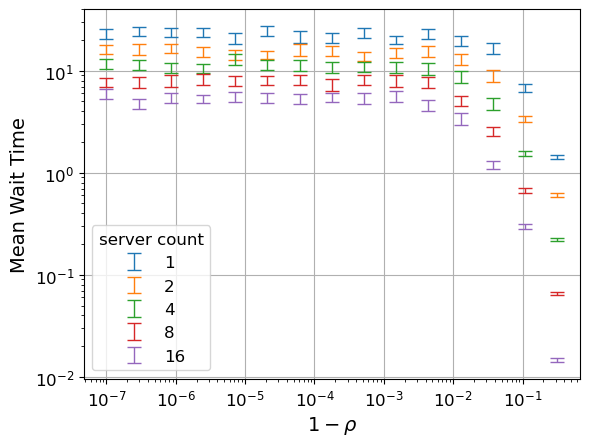

In [ ]:
# system load errorbar

server_counts = [1, 2, 4, 8, 16]
num_runs = 100
rand.seed(42)
system_loads = 1 - np.logspace(-0.5, -7, 15)
mean_wait_time = np.zeros_like(system_loads)
std_wait_time = np.zeros_like(system_loads)
for server_count in server_counts:
    for i, system_load in enumerate(system_loads):
        wait_times = np.zeros(num_runs)
        for j in range(num_runs):
            
            res = M_M_n_simulation(system_load, server_count, 1000, seed=rand.randint(0,2**31-1))
            wait_times[j] = res['Average Wait Time']

        mean_wait_time[i] = np.mean(wait_times)
        std_wait_time[i] = np.std(wait_times)
    # plt.plot(1 - system_loads, mean_wait_time, label=f'{server_count}')
    print(server_count, np.mean(wait_times[-1]))
    plt.errorbar(1 - system_loads, mean_wait_time, 1.96*std_wait_time/np.sqrt(num_runs), linestyle='', label=f'{server_count}', capsize=5, elinewidth=1)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$1-\rho$', fontsize=14) 
plt.ylabel('Mean Wait Time', fontsize=14) 
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 
plt.legend(title='server count', title_fontsize=12, fontsize=12)


## plots for duration

In [ ]:
# duration - error bars

server_counts = [1, 2, 4]
num_runs = 1
rand.seed(42)
system_load = 0.99
max_duration = np.logspace(1, 7, 15)
mean_wait_time = np.zeros_like(max_duration)
std_wait_time = np.zeros_like(max_duration)
for server_count in server_counts:
    for i, duration in enumerate(max_duration):
        wait_times = np.zeros(num_runs)
        for j in range(num_runs):
            
            res = M_M_n_simulation(system_load, server_count, duration, seed=rand.randint(0,2**31-1))
            wait_times[j] = res['Average Wait Time']

        mean_wait_time[i] = np.mean(wait_times)
        std_wait_time[i] = np.std(wait_times)
    print(server_count, np.mean(wait_times[-1]))
    plt.errorbar(max_duration, mean_wait_time, 1.96*std_wait_time/np.sqrt(num_runs), linestyle='', label=f'{server_count}', capsize=5, elinewidth=1)
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'simulation duration')
plt.ylabel('mean wait time')
plt.legend(title='server count')

## 3) FIFO & SFJ


In [ ]:
server_counts = [1]
num_runs = 100
rand.seed(42)
system_loads = 1 - np.logspace(-0.5, -7, 15)

for queue_type in ['FIFO', 'SJF']:
    for server_count in server_counts:
        mean_wait_time = np.zeros_like(system_loads)
        std_wait_time = np.zeros_like(system_loads)
        for i, system_load in enumerate(system_loads):
            wait_times = np.zeros(num_runs)
            for j in range(num_runs):
                res = M_M_n_simulation(
                    system_load, server_count, 1000, seed=rand.randint(0, 2**31 - 1), queue_type=queue_type
                )
                wait_times[j] = res['Average Wait Time']

            mean_wait_time[i] = np.mean(wait_times)
            std_wait_time[i] = np.std(wait_times)
        plt.errorbar(
            1 - system_loads,
            mean_wait_time,
            std_wait_time,
            linestyle='',
            label=f'{queue_type}',
            capsize=5,
            elinewidth=1,
        )

plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$1-\rho$', fontsize=14) 
plt.ylabel('Mean Wait Time', fontsize=14) 
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 
plt.legend(title='Queue Type', title_fontsize=12, fontsize=12)
plt.show()


## 4) Different Service Rate Distributions


All Data Points for Waiting Times:
Exponential Waiting Times: [7.8220963041293, 7.294769255864776, 8.050630386997483, 8.220104034674893, 8.663045519903587, 8.400975420208871, 8.226578960744575, 7.960361427203703, 7.799672677609455, 7.578646363095852, 8.647274186716205, 8.012631011068201, 8.18356714747944, 8.49773130132169, 7.6572238130524095, 7.765513339709203, 7.307099758844518, 7.947551600780007, 8.325656888466433, 7.459884792055437, 8.193452576208962, 7.806944834193531, 7.137523786502229, 8.388734611012437, 8.39574116600413, 7.486576585035933, 8.658860536075991, 7.566457600087114, 7.4109375844998, 8.983923186451339, 8.30368040280455, 8.103292423888648, 7.201704189812344, 7.4229332614670085, 7.786557064890758, 8.38289722658554, 7.703208870618825, 8.350432830971448, 8.928934804710215, 7.80454360717621, 8.731743980687607, 9.337056865803499, 8.407823678698447, 7.567063473038739, 8.897676750164107, 8.512408087382074, 7.482391649934699, 7.876650415008916, 7.820953215219073, 8.31301267278

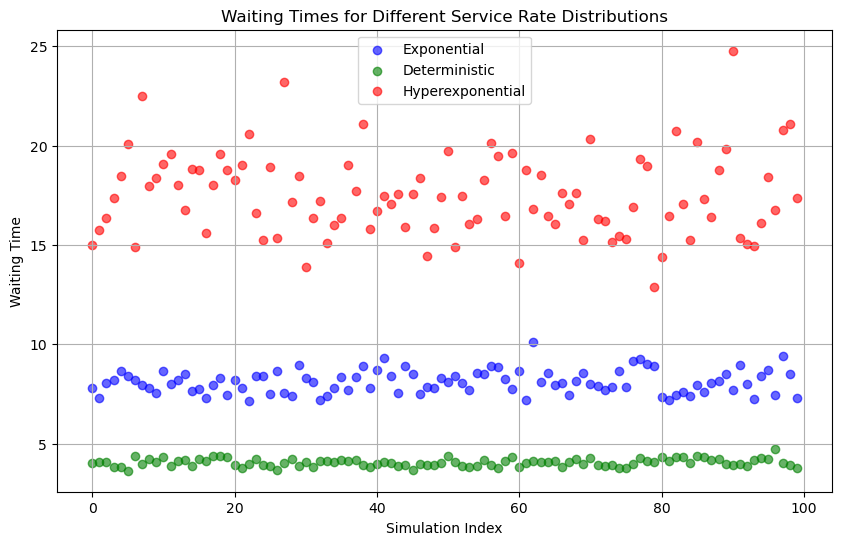

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy.random as rand

def M_X_n_simulation(system_load, server_count, sim_duration, seed=None, service_dist=None):
    """
    Simulates an M/X/n queueing system.

    Parameters:
    - system_load: The load factor of the system (λ/μ).
    - server_count: The number of servers in the system.
    - sim_duration: The duration of the simulation.
    - seed: Seed for the random number generator to ensure reproducibility (default is None).
    - service_dist: Custom service distribution (default is exponential).

    Returns:
    - sim.results(): Results of the queueing simulation.
    """

    if seed is not None:
        rand.seed(seed)

    # Set arrival rate and job completion rate
    arrival_rate = server_count
    job_completion_rate = 1 / system_load
    
    arrival_dist = lambda: rand.exponential(1 / arrival_rate)

    # Use default exponential service distribution if none is provided
    if service_dist is None:
        service_dist = lambda: rand.exponential(1 / job_completion_rate)

    # Initialize and run the simulation
    sim = ServerQueueingSimulation(arrival_dist, service_dist, server_count, sim_duration=sim_duration, seed=seed)
    
    return sim.results()

def run_simulations():
    """
    Runs simulations for different service distributions and returns waiting times.

    Returns:
    - waiting_times: Dictionary containing waiting times for each service distribution.
    """
    waiting_times = {'exponential': [], 'deterministic': [], 'hyperexponential': []}

    for service_type in ['exponential', 'deterministic', 'hyperexponential']:
        for i in range(100):
            service_rate = 1 / 0.9
            seed = i

            if service_type == 'exponential':
                service_dist = lambda: rand.exponential(1 / service_rate)

            elif service_type == 'deterministic':
                service_dist = lambda: 1 / service_rate

            elif service_type == 'hyperexponential':
                def service_dist():
                    if rand.rand() < 0.5:
                        return rand.exponential(0.9)
                    else:
                        return rand.exponential(1)

            else:
                raise ValueError("Unsupported service time distribution")
            
            result = M_X_n_simulation(0.9, 1, 100000, seed=seed, service_dist=service_dist)
            waiting_times[service_type].append(result['Average Wait Time'])
    
    return waiting_times

def calculate_and_display_stats(waiting_times):
    """
    Calculates and displays statistics for different service distributions.

    Parameters:
    - waiting_times: Dictionary containing waiting times for each service distribution.
    """
    # Output all data points for each distribution
    print("\nAll Data Points for Waiting Times:")
    for service_type in waiting_times:
        print(f"{service_type.capitalize()} Waiting Times: {waiting_times[service_type]}")

    # Print summary statistics for each distribution
    means = {}
    std_devs = {}
    for service_type in waiting_times:
        mean_wait = np.mean(waiting_times[service_type])
        std_wait = np.std(waiting_times[service_type])
        means[service_type] = mean_wait
        std_devs[service_type] = std_wait
        print(f"{service_type.capitalize()} - Mean Waiting Time: {mean_wait:.4f}, Std Dev: {std_wait:.4f}")

    # ANOVA to test if there are significant differences between the average waiting times
    f_stat, p_value = stats.f_oneway(waiting_times['exponential'], waiting_times['deterministic'], waiting_times['hyperexponential'])
    print(f"\nANOVA F-statistic: {f_stat:.4f}, p-value: {p_value:.4g}")

    # Pairwise t-tests to further analyze differences between distributions
    t_exp_det, p_exp_det = stats.ttest_ind(waiting_times['exponential'], waiting_times['deterministic'])
    t_exp_hyper, p_exp_hyper = stats.ttest_ind(waiting_times['exponential'], waiting_times['hyperexponential'])
    t_det_hyper, p_det_hyper = stats.ttest_ind(waiting_times['deterministic'], waiting_times['hyperexponential'])

    print("\nPairwise T-tests Results:")
    print(f"Exponential vs Deterministic: t-statistic = {t_exp_det:.4f}, p-value = {p_exp_det:.4g}")
    print(f"Exponential vs Hyperexponential: t-statistic = {t_exp_hyper:.4f}, p-value = {p_exp_hyper:.4g}")
    print(f"Deterministic vs Hyperexponential: t-statistic = {t_det_hyper:.4f}, p-value = {p_det_hyper:.4g}")

    # Create a scatter plot to visualize mean waiting times with their standard deviations
    plt.figure(figsize=(10, 6))
    colors = {'exponential': 'b', 'deterministic': 'g', 'hyperexponential': 'r'}
    for service_type in waiting_times:
        x = np.arange(len(waiting_times[service_type]))
        y = waiting_times[service_type]
        plt.scatter(x, y, label=service_type.capitalize(), alpha=0.6, color=colors[service_type])

    plt.xlabel('Simulation Index')
    plt.ylabel('Waiting Time')
    plt.title('Waiting Times for Different Service Rate Distributions')
    plt.legend()
    plt.grid(True)
    plt.show()

def run_simulations_varying_rho_service_distributions():
    """
    Runs simulations for different service distributions with varying system load (rho).

    Returns:
    - A plot showing mean waiting times with confidence intervals for each service distribution.
    """
    service_distributions = ['exponential', 'deterministic', 'hyperexponential']
    num_runs = 20
    system_loads = np.linspace(0.4, 0.99, 10)
    durations = 100000 * np.ones_like(system_loads)
    durations[7:] *= 5
    
    rand.seed(42)
    plt.figure(figsize=(10, 6))
    
    for service_type in service_distributions:
        mean_wait_time = np.zeros_like(system_loads)
        std_wait_time = np.zeros_like(system_loads)
        
        # Loop over different system loads (rho values)
        for i, system_load in enumerate(system_loads):
            sim_duration = durations[i]
            wait_times = np.zeros(num_runs)
            
            # Run multiple simulations to collect data for statistical analysis
            for j in range(num_runs):
                seed = rand.randint(0, 2**31 - 1)
                
                # Define service distribution based on type
                if service_type == 'exponential':
                    service_dist = lambda: rand.exponential(1 / (1 / 0.9))
                elif service_type == 'deterministic':
                    service_dist = lambda: 1 / (1 / 0.9)
                elif service_type == 'hyperexponential':
                    def service_dist():
                        if rand.rand() < 0.5:
                            return rand.exponential(0.9)
                        else:
                            return rand.exponential(1)
                else:
                    raise ValueError("Unsupported service time distribution")
                
                # Run the simulation and record the average waiting time
                res = M_X_n_simulation(system_load, 1, sim_duration, seed=seed, service_dist=service_dist)
                wait_times[j] = res['Average Wait Time']
            
            # Calculate mean and standard deviation of waiting times for the current system load
            mean_wait_time[i] = np.mean(wait_times)
            std_wait_time[i] = np.std(wait_times)
        
        # Plotting mean waiting time with confidence intervals for the current service distribution
        plt.errorbar(1 - system_loads, mean_wait_time, 
                     yerr=1.96 * std_wait_time / np.sqrt(num_runs), 
                     linestyle='', label=f'{service_type.capitalize()}', capsize=5, elinewidth=1)
    
    # Configure plot appearance
    plt.grid()
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$1-\rho$', fontsize=14)
    plt.ylabel('Mean Wait Time', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Service Distribution', title_fontsize=12, fontsize=12)
    plt.title('Mean Wait Time vs System Load for Different Service Distributions')
    plt.show()

# Example Usage
waiting_times = run_simulations()
calculate_and_display_stats(waiting_times)
run_simulations_varying_rho_service_distributions()
